In [1]:
%matplotlib inline
import nivapy3 as nivapy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# Process EMEP Hg deposition

Hans Fredrik has been sent wet and dry Hg deposition data from EMEP. The data use the new 0.1 by 0.1 degree EMEP grid, as defined [here](http://www.ceip.at/ms/ceip_home1/ceip_home/new_emep-grid/grid_definition/). Deposition is reported separately for each land use class in each grid cell, further sub-divided into "wet" and "dry". 

The table `'LandCover_NO.csv'` lists the proportions of each land cover type in each grid cell. For each land cover type, there are two further files: `'hg_dry_XXXX_NO.csv'` and `'hg_wet_XXXX_NO.csv'`, where `'XXXX'` is the land cover class. These files give the wet or dry Hg deposition to the specified land cover class in units of  g/km2/yr. 

Hans Fredrik would like a file with one row per EMEP grid cell, and two columns per land use class (one for wet deposition and one for dry). The workflow will look something like this:

 1. Calculate the area for each EMEP grid cell
 
 2. Using the areas from (1) and the proportions in `'LandCover_NO.csv'`, calculate the area of each land cover class in each grid cell
 
 3. Using `'hg_dry_XXXX_NO.csv'`, `'hg_wet_XXXX_NO.csv'` and the areas from (2), calculate wet and dry Hg deposition inputs to each land class in each grid cell
 
 4. Join the datasets together and tidy
 
## 1. EMEP grid

I have downloaded a shapefile for the Norwegian portion of the 0.1 degree EMEP grid from [here](http://www.ceip.at/ms/ceip_home1/ceip_home/new_emep-grid/grid_definition/). Each cell can be uniquely identified by ('lon', 'lat') co-ordinates, which identify the centre of each cell. Furthermore, there is an `'area'` field that provides cell areas in km2 and a `'frac_area'` field that provides the areas of each cell within Norway. **I am assuming that the land cover proportion in `'LandCover_NO.csv'` area based on the `'frac_area'` field**.

In [2]:
# Read shapefile
in_shp = (r'C:\Data\James_Work\Staff\Hans_Fredrik_B\EMEP_Hg_Dep'
          r'\data\gis\EMEP_GRID_01x01DEG_NO.shp')
gdf = gpd.read_file(in_shp)

# Rename 'long' and 'lon'
gdf['lon'] = gdf['long']
del gdf['long']

gdf.head()

,long_min,long_max,lat_min,lat_max,lat,ISO,fraction,area,frac_area,Name,Number,geometry,lon
0,6.9,7.0,57.9,58.0,57.95,NO,0.003423,65.952005,0.225781,Norway,18,"POLYGON ((7.000000000499654 57.89999999950044,...",6.95
1,7.0,7.1,57.9,58.0,57.95,NO,0.092032,65.952004,6.069710,Norway,18,"POLYGON ((7.100000000299815 57.89999999950044,...",7.05
2,7.1,7.2,57.9,58.0,57.95,NO,0.002899,65.952004,0.191206,Norway,18,"POLYGON ((7.200000000099976 57.89999999950044,...",7.15
3,7.2,7.3,57.9,58.0,57.95,NO,0.011433,65.952004,0.754015,Norway,18,"POLYGON ((7.299999999900137 57.89999999950044,...",7.25
4,7.3,7.4,57.9,58.0,57.95,NO,0.033448,65.952005,2.205934,Norway,18,"POLYGON ((7.400000000599618 57.89999999950044,...",7.35


## 2. Land cover proportions

In [3]:
# Read LC props
lc_path = (r'C:\Data\James_Work\Staff\Hans_Fredrik_B\EMEP_Hg_Dep'
           r'\data\hg_dep\LandCover_NO.csv')
lc_df = pd.read_csv(lc_path, skiprows=2, skipinitialspace=True)

# Get list of unique LC names
lc_list = list(set(lc_df.columns) - set(['i', 'j', 'lon', 'lat']))

lc_df.head()

,i,j,lon,lat,Water,EvNeedl,EvBroad,DecNeedl,DecBroad,MixedFor,...,OpenShrub,WoodSav,Savanna,Grassland,Wetland,Cropland,Urban,Crop_NatVeg,Snow_Ice,Bar_SparVeg
0,370,280,6.95,57.95,1.00000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.00000,0.000000,0.0,0.0
1,371,280,7.05,57.95,0.96710,0.025977,0.0,0.0,0.000000,0.006926,...,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.00000,0.000000,0.0,0.0
2,366,281,6.55,58.05,0.94967,0.019084,0.0,0.0,0.005207,0.017354,...,0.0,0.000000,0.000000,0.0,0.006946,0.00000,0.00000,0.001735,0.0,0.0
3,367,281,6.65,58.05,0.37728,0.260120,0.0,0.0,0.008682,0.284480,...,0.0,0.017349,0.010419,0.0,0.010424,0.01562,0.00347,0.008676,0.0,0.0
4,368,281,6.75,58.05,0.37728,0.260120,0.0,0.0,0.008682,0.284480,...,0.0,0.017349,0.010419,0.0,0.010424,0.01562,0.00347,0.008676,0.0,0.0


In [4]:
# Check that all proportions add to 1
print ('Min:', lc_df[lc_list].sum(axis=1).min())
print ('Max:', lc_df[lc_list].sum(axis=1).max())

Min: 0.9999818999999999
Max: 1.0000149999999999


In [5]:
# Join to spatial data
gdf = gdf.merge(lc_df, 
                on=['lon', 'lat'])

gdf.head()

,long_min,long_max,lat_min,lat_max,lat,ISO,fraction,area,frac_area,Name,...,OpenShrub,WoodSav,Savanna,Grassland,Wetland,Cropland,Urban,Crop_NatVeg,Snow_Ice,Bar_SparVeg
0,6.9,7.0,57.9,58.0,57.95,NO,0.003423,65.952005,0.225781,Norway,...,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.00000,0.000000,0.0,0.0
1,7.0,7.1,57.9,58.0,57.95,NO,0.092032,65.952004,6.069710,Norway,...,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.00000,0.000000,0.0,0.0
2,6.5,6.6,58.0,58.1,58.05,NO,0.018951,65.769437,1.246416,Norway,...,0.0,0.000000,0.000000,0.0,0.006946,0.00000,0.00000,0.001735,0.0,0.0
3,6.6,6.7,58.0,58.1,58.05,NO,0.259841,65.769437,17.089623,Norway,...,0.0,0.017349,0.010419,0.0,0.010424,0.01562,0.00347,0.008676,0.0,0.0
4,6.7,6.8,58.0,58.1,58.05,NO,0.349332,65.769437,22.975351,Norway,...,0.0,0.017349,0.010419,0.0,0.010424,0.01562,0.00347,0.008676,0.0,0.0


## 3. Calculate land areas for each cover class

In [6]:
# Loop over classes
for lc in lc_list:
    gdf['%s_km2' % lc] = gdf['frac_area'] * gdf[lc]

## 4. Calculate dry deposition for each land cover class in each cell

In [7]:
# Loop over classes
for lc in lc_list:
    # Read dry dep data
    dry_path = (r'C:\Data\James_Work\Staff\Hans_Fredrik_B\EMEP_Hg_Dep'
                r'\data\hg_dep\hg_dry_%s_NO.csv' % lc)
    dry_df = pd.read_csv(dry_path, skiprows=2, skipinitialspace=True)
    
    # Join
    gdf = gdf.merge(dry_df, 
                    on=['lon', 'lat'])
    
    # Calc flux to cell
    gdf['dry_%s_g' % lc] = gdf['%s_km2' % lc] * gdf['dep flux']
    del gdf['dep flux']    

## 5. Calculate wet deposition for each land cover class in each cell

In [8]:
# Loop over classes
for lc in lc_list:
    # Read wet dep data
    wet_path = (r'C:\Data\James_Work\Staff\Hans_Fredrik_B\EMEP_Hg_Dep'
                r'\data\hg_dep\hg_wet_%s_NO.csv' % lc)
    wet_df = pd.read_csv(dry_path, skiprows=2, skipinitialspace=True)
    
    # Join
    gdf = gdf.merge(wet_df, 
                    on=['lon', 'lat'])
    
    # Calc flux to cell
    gdf['wet_%s_g' % lc] = gdf['%s_km2' % lc] * gdf['dep flux']
    del gdf['dep flux']

## 6. Sum dry

In [9]:
# Sum dry dep
cols = ['dry_%s_g' % i for i in lc_list]
gdf['total_dry_g'] = gdf[cols].sum(axis=1)

## 7. Sum wet

In [10]:
# Sum wet dep
cols = ['wet_%s_g' % i for i in lc_list]
gdf['total_wet_g'] = gdf[cols].sum(axis=1)

## 8. Tidy

In [11]:
# Get data of interest
cols = ['geometry', 'lon', 'lat', 'area', 'frac_area']

# Add cols for wet and dry dep
for lc in lc_list:
    cols.append('dry_%s_g' % lc)
    cols.append('wet_%s_g' % lc)
    
# Add totals
cols.append('total_dry_g')
cols.append('total_wet_g')
    
# Extract data
gdf = gdf[cols]

# Overall total
gdf['total_dep_g'] = gdf['total_dry_g'] + gdf['total_wet_g']

gdf.head()

,geometry,lon,lat,area,frac_area,dry_WoodSav_g,wet_WoodSav_g,dry_Savanna_g,wet_Savanna_g,dry_Grassland_g,...,wet_Urban_g,dry_ClosShrub_g,wet_ClosShrub_g,dry_DecBroad_g,wet_DecBroad_g,dry_Wetland_g,wet_Wetland_g,total_dry_g,total_wet_g,total_dep_g
0,"POLYGON ((7.000000000499654 57.89999999950044,...",6.95,57.95,65.952005,0.225781,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.093284,0.000000,0.093284
1,"POLYGON ((7.100000000299815 57.89999999950044,...",7.05,57.95,65.952004,6.069710,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.369990,0.000000,4.369990
2,"POLYGON ((6.600000000399746 58.00000000019992,...",6.55,58.05,65.769437,1.246416,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.049293,0.008508,0.011349,0.011349,0.889344,1.633920,2.523264
3,"POLYGON ((6.700000000199907 58.00000000019992,...",6.65,58.05,65.769437,17.089623,0.392224,0.326137,0.195862,0.195862,0.0,...,0.065231,0.074061,0.065325,0.861359,0.163209,0.195956,0.195956,68.751765,18.798491,87.550256
4,"POLYGON ((6.800000000000068 58.00000000019992,...",6.75,58.05,65.769437,22.975351,0.527307,0.438459,0.263318,0.263318,0.0,...,0.087697,0.099568,0.087823,1.158015,0.219419,0.263445,0.263445,92.430122,25.272760,117.702882


## 9. Save

In [12]:
# Save as geojson
out_json = (r'C:\Data\James_Work\Staff\Hans_Fredrik_B\EMEP_Hg_Dep'
            r'\data\gis\emep_hg_dep.geojson')
gdf.to_file(out_json, driver='GeoJSON')

In [13]:
# Save as CSV
out_csv = (r'C:\Data\James_Work\Staff\Hans_Fredrik_B\EMEP_Hg_Dep'
           r'\data\emep_hg_dep.csv')
df = pd.DataFrame(gdf)
df.to_csv(out_csv, index=False)

## 10. Map

The map below shows total Hg deposition per km2 *in Norway*.

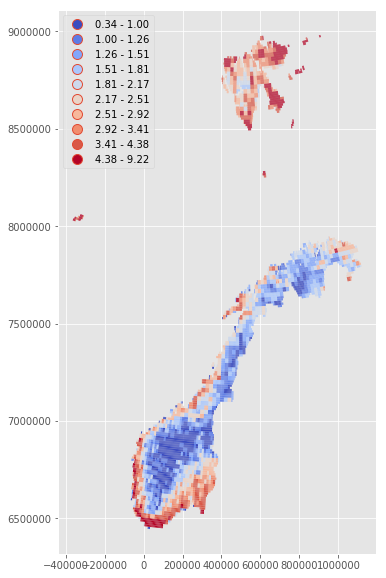

In [15]:
# Calc value per km2 in Norway to appearance is more 'even'
gdf['total_dep_g/km2'] = gdf['total_dep_g'] / gdf['frac_area']

# Project to UTM Z33N
gdf2 = gdf.to_crs({'init':'epsg:32633'})

# Plot
gdf2.plot(column='total_dep_g/km2', 
          cmap='coolwarm', 
          scheme='quantiles',
          k=10,
          legend=True,
          legend_kwds={'loc':'upper left'},
          figsize=(10,10)) 